# Adoption Scenario Matrix Analysis

This notebook analyzes different blockchain adoption scenarios from conservative to aggressive, evaluating financial outcomes under various market conditions.

## Objectives

1. Define realistic adoption scenarios with constraints
2. Analyze financial outcomes for each scenario
3. Calculate breakeven adoption rate
4. Sensitivity analysis on scenario parameters
5. Provide implementation recommendations


In [ ]:
import sys

sys.path.insert(0, "..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import extract_10k_metrics, format_currency
from src.cost_model import PaymentFlowParams
from src.scenarios import (
    AdoptionScenario,
    SCENARIOS,
    ScenarioResults,
    run_scenario_analysis,
    run_all_scenarios,
    scenarios_to_dataframe,
    get_scenario_summary,
    calculate_breakeven_scenario,
    sensitivity_by_scenario_parameter,
)

# Plot styling
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 11

## 1. Scenario Definitions

Define adoption scenarios from conservative to aggressive, each with different assumptions about market conditions.


In [ ]:
# Display predefined scenarios
print("Predefined Adoption Scenarios")
print("=" * 80)

scenario_details = []
for key, scenario in SCENARIOS.items():
    scenario_details.append(
        {
            "Scenario": scenario.name,
            "Target Adoption": f"{scenario.adoption_rate:.0%}",
            "Shipper Escrow": f"{scenario.shipper_escrow_pct:.0%}",
            "Carrier Ready": f"{scenario.carrier_tech_ready_pct:.0%}",
            "Effective Adoption": f"{scenario.effective_adoption:.0%}",
            "Tx Cost": f"${scenario.tx_cost_per_load:.0f}",
            "Fraud Reduction": f"{scenario.fraud_reduction_pct:.0%}",
            "Regulatory": "Yes" if scenario.regulatory_approval else "No",
        }
    )

pd.DataFrame(scenario_details)

Predefined Adoption Scenarios


,Scenario,Target Adoption,Shipper Escrow,Carrier Ready,Effective Adoption,Tx Cost,Fraud Reduction,Regulatory
0,Conservative,10%,20%,50%,10%,$10,5%,No
1,Base Case,30%,40%,70%,30%,$5,15%,Yes
2,Optimistic,50%,60%,85%,50%,$3,25%,Yes
3,Aggressive,75%,80%,95%,75%,$2,40%,Yes


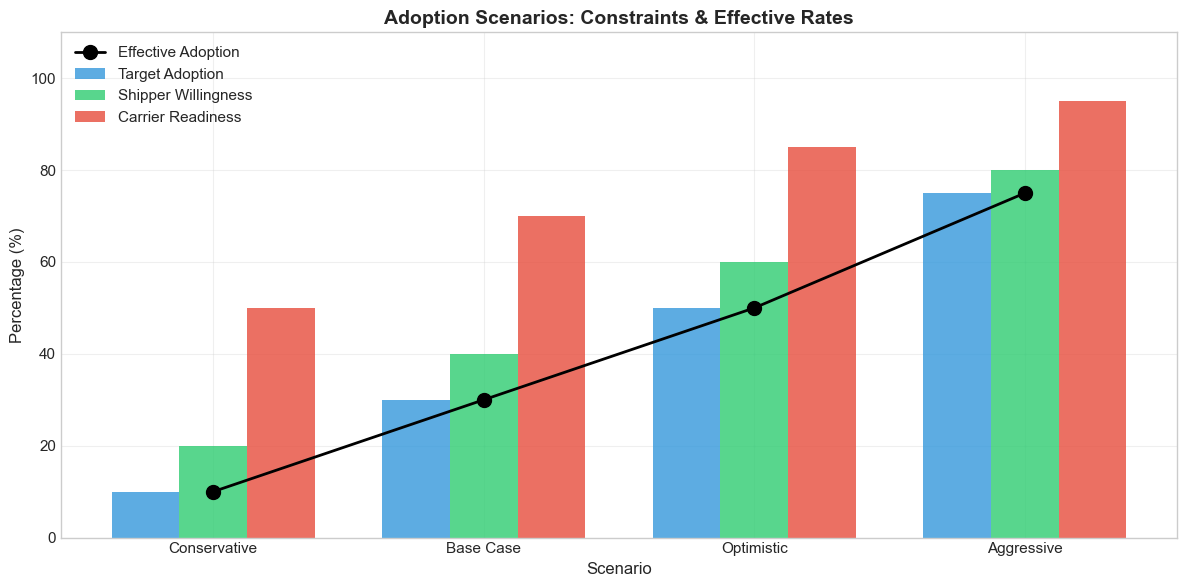

In [ ]:
# Visualize scenario constraints
fig, ax = plt.subplots(figsize=(12, 6))

scenarios_list = list(SCENARIOS.values())
scenario_names = [s.name for s in scenarios_list]
x = np.arange(len(scenario_names))
width = 0.25

bars1 = ax.bar(
    x - width,
    [s.adoption_rate * 100 for s in scenarios_list],
    width,
    label="Target Adoption",
    color="#3498db",
    alpha=0.8,
)
bars2 = ax.bar(
    x,
    [s.shipper_escrow_pct * 100 for s in scenarios_list],
    width,
    label="Shipper Willingness",
    color="#2ecc71",
    alpha=0.8,
)
bars3 = ax.bar(
    x + width,
    [s.carrier_tech_ready_pct * 100 for s in scenarios_list],
    width,
    label="Carrier Readiness",
    color="#e74c3c",
    alpha=0.8,
)

# Add effective adoption line
ax.plot(
    x,
    [s.effective_adoption * 100 for s in scenarios_list],
    "ko-",
    linewidth=2,
    markersize=10,
    label="Effective Adoption",
)

ax.set_xlabel("Scenario", fontsize=12)
ax.set_ylabel("Percentage (%)", fontsize=12)
ax.set_title(
    "Adoption Scenarios: Constraints & Effective Rates", fontsize=14, fontweight="bold"
)
ax.set_xticks(x)
ax.set_xticklabels(scenario_names)
ax.legend(loc="upper left")
ax.set_ylim(0, 110)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("results/figures", dpi=150, bbox_inches="tight")
plt.show()

## 2. Scenario Analysis Results

Run financial analysis for all scenarios.


In [4]:
# Initialize base parameters from 10-K data
metrics = extract_10k_metrics(2024)

params = PaymentFlowParams(
    annual_revenue=metrics["total_revenue"] * 1e6,
    loads_per_year=metrics["shipments_handled"],
    dso_days=metrics["dso"],
    dpo_days=metrics["dpo"],
    cost_of_capital=0.07,
    factoring_rate=0.03,
    fraud_loss_rate=0.005,
    admin_cost_per_load=15.0,
)

# Run all scenarios
results = run_all_scenarios(params, discount_rate=0.10)

# Convert to DataFrame
results_df = scenarios_to_dataframe(results)
print("Scenario Analysis Results")
print("=" * 80)
results_df[
    [
        "scenario",
        "adoption_rate",
        "effective_adoption",
        "net_savings",
        "roi",
        "payback_years",
        "npv_5yr",
    ]
]

Scenario Analysis Results


,scenario,adoption_rate,effective_adoption,net_savings,roi,payback_years,npv_5yr
0,Conservative,10%,10%,9.780186e+06,0.130402,7.668566,-3.792540e+07
1,Base Case,30%,30%,9.054556e+07,1.810911,0.552208,2.932389e+08
2,Optimistic,50%,50%,1.797009e+08,4.492523,0.222592,6.412079e+08
3,Aggressive,75%,75%,2.962826e+08,8.465218,0.118130,1.088144e+09


In [5]:
# Detailed results for each scenario
for key, result in results.items():
    print(f"\n{result.scenario.name} Scenario")
    print("-" * 50)
    print(f"Effective Adoption: {result.scenario.effective_adoption:.0%}")
    print(f"Net Annual Savings: {format_currency(result.net_savings)}")
    print(
        f"Implementation Cost: {format_currency(result.scenario.implementation_cost)}"
    )
    print(
        f"Annual Maintenance: {format_currency(result.scenario.annual_maintenance_cost)}"
    )
    print(f"ROI: {result.roi:.1%}")
    print(f"Payback Period: {result.payback_years:.1f} years")
    print(f"5-Year NPV: {format_currency(result.npv_5yr)}")


Conservative Scenario
--------------------------------------------------
Effective Adoption: 10%
Net Annual Savings: $9.8M
Implementation Cost: $75.0M
Annual Maintenance: $15.0M
ROI: 13.0%
Payback Period: 7.7 years
5-Year NPV: -$37.9M

Base Case Scenario
--------------------------------------------------
Effective Adoption: 30%
Net Annual Savings: $90.5M
Implementation Cost: $50.0M
Annual Maintenance: $10.0M
ROI: 181.1%
Payback Period: 0.6 years
5-Year NPV: $293.2M

Optimistic Scenario
--------------------------------------------------
Effective Adoption: 50%
Net Annual Savings: $179.7M
Implementation Cost: $40.0M
Annual Maintenance: $8.0M
ROI: 449.3%
Payback Period: 0.2 years
5-Year NPV: $641.2M

Aggressive Scenario
--------------------------------------------------
Effective Adoption: 75%
Net Annual Savings: $296.3M
Implementation Cost: $35.0M
Annual Maintenance: $7.0M
ROI: 846.5%
Payback Period: 0.1 years
5-Year NPV: $1.1B


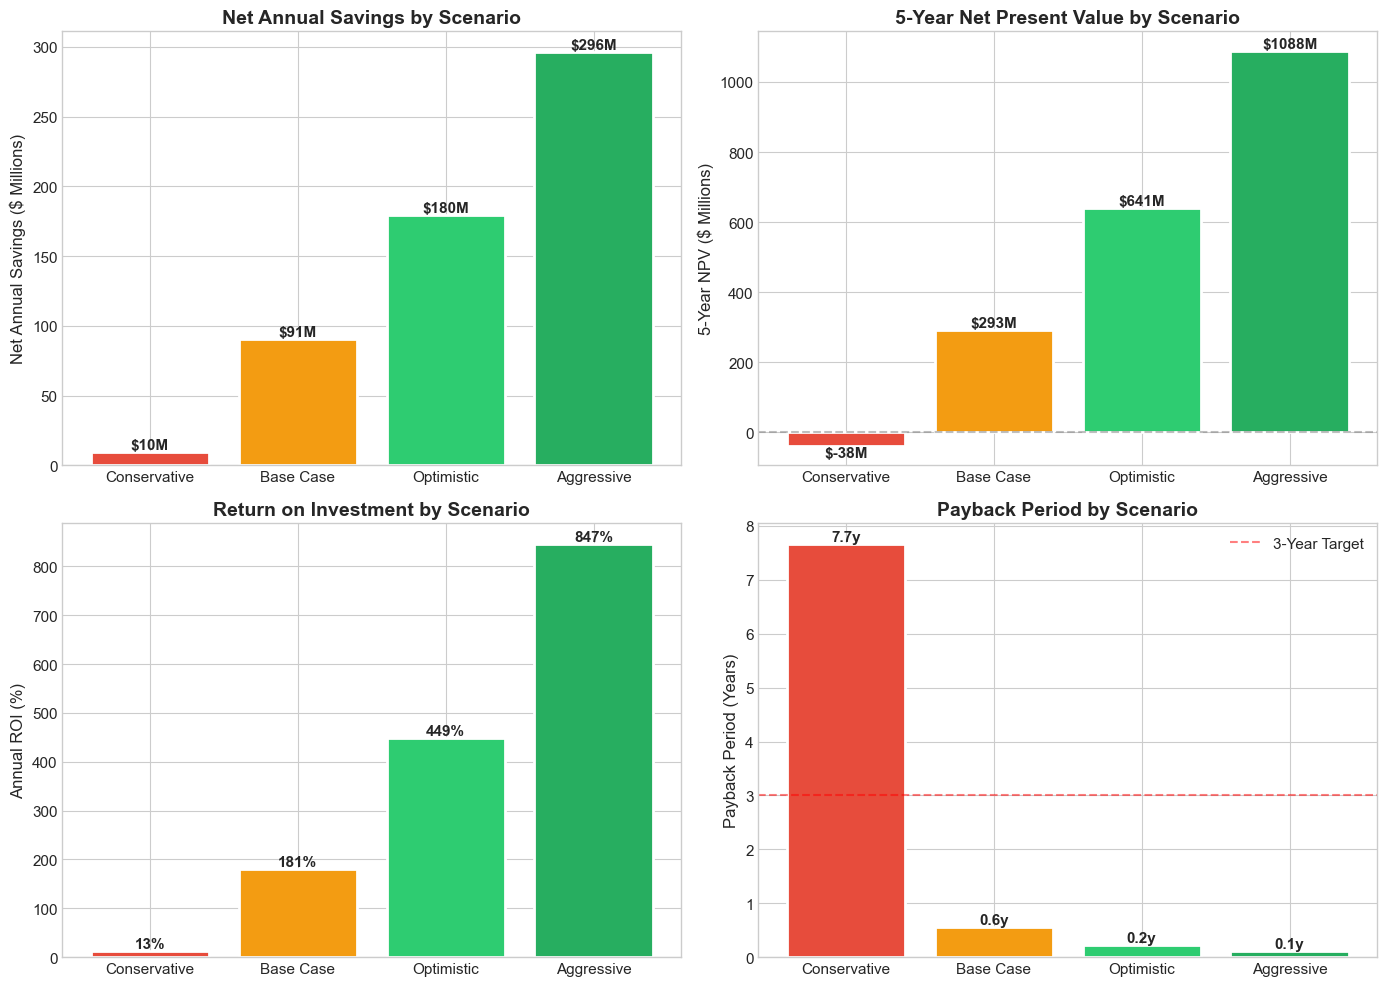

In [7]:
# Visualize scenario comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

scenarios = list(results.values())
names = [s.scenario.name for s in scenarios]
colors = ["#e74c3c", "#f39c12", "#2ecc71", "#27ae60"]

# Net savings comparison
savings = [r.net_savings / 1e6 for r in scenarios]
bars = axes[0, 0].bar(names, savings, color=colors, edgecolor="white", linewidth=2)
axes[0, 0].set_ylabel("Net Annual Savings ($ Millions)", fontsize=12)
axes[0, 0].set_title("Net Annual Savings by Scenario", fontsize=14, fontweight="bold")
for bar, val in zip(bars, savings):
    axes[0, 0].annotate(
        f"${val:.0f}M",
        xy=(bar.get_x() + bar.get_width() / 2, val),
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

# 5-Year NPV comparison
npvs = [r.npv_5yr / 1e6 for r in scenarios]
bars = axes[0, 1].bar(names, npvs, color=colors, edgecolor="white", linewidth=2)
axes[0, 1].set_ylabel("5-Year NPV ($ Millions)", fontsize=12)
axes[0, 1].set_title(
    "5-Year Net Present Value by Scenario", fontsize=14, fontweight="bold"
)
axes[0, 1].axhline(y=0, color="gray", linestyle="--", alpha=0.5)
for bar, val in zip(bars, npvs):
    va = "bottom" if val >= 0 else "top"
    axes[0, 1].annotate(
        f"${val:.0f}M",
        xy=(bar.get_x() + bar.get_width() / 2, val),
        ha="center",
        va=va,
        fontsize=11,
        fontweight="bold",
    )

# ROI comparison
rois = [r.roi * 100 for r in scenarios]
bars = axes[1, 0].bar(names, rois, color=colors, edgecolor="white", linewidth=2)
axes[1, 0].set_ylabel("Annual ROI (%)", fontsize=12)
axes[1, 0].set_title("Return on Investment by Scenario", fontsize=14, fontweight="bold")
for bar, val in zip(bars, rois):
    axes[1, 0].annotate(
        f"{val:.0f}%",
        xy=(bar.get_x() + bar.get_width() / 2, val),
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

# Payback period comparison
paybacks = [r.payback_years for r in scenarios]
bars = axes[1, 1].bar(names, paybacks, color=colors, edgecolor="white", linewidth=2)
axes[1, 1].set_ylabel("Payback Period (Years)", fontsize=12)
axes[1, 1].set_title("Payback Period by Scenario", fontsize=14, fontweight="bold")
axes[1, 1].axhline(y=3, color="red", linestyle="--", alpha=0.5, label="3-Year Target")
for bar, val in zip(bars, paybacks):
    axes[1, 1].annotate(
        f"{val:.1f}y",
        xy=(bar.get_x() + bar.get_width() / 2, val),
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )
axes[1, 1].legend()

plt.tight_layout()
plt.savefig("results/figures.png", dpi=150, bbox_inches="tight")
plt.show()

## 3. Breakeven Analysis

Determine the minimum adoption rate needed to achieve positive ROI.


In [8]:
# Calculate breakeven adoption rates for different scenarios
implementation_costs = [25e6, 50e6, 75e6, 100e6]
tx_costs = [2, 5, 10]

breakeven_data = []
for impl_cost in implementation_costs:
    for tx_cost in tx_costs:
        be_rate = calculate_breakeven_scenario(params, impl_cost, 10e6, tx_cost)
        breakeven_data.append(
            {
                "Implementation Cost": f"${impl_cost / 1e6:.0f}M",
                "Tx Cost": f"${tx_cost}",
                "Breakeven Adoption": f"{be_rate:.1%}",
            }
        )

breakeven_df = pd.DataFrame(breakeven_data)
print("Breakeven Adoption Rates")
print("=" * 50)
print("(Target: 3-year payback period)")
breakeven_df.pivot(
    index="Implementation Cost", columns="Tx Cost", values="Breakeven Adoption"
)

Breakeven Adoption Rates
(Target: 3-year payback period)


Tx Cost,$10,$2,$5
Implementation Cost,,,
$100M,17.3%,11.4%,13.0%
$25M,7.1%,4.8%,5.5%
$50M,10.2%,7.1%,7.9%
$75M,13.4%,9.1%,10.2%


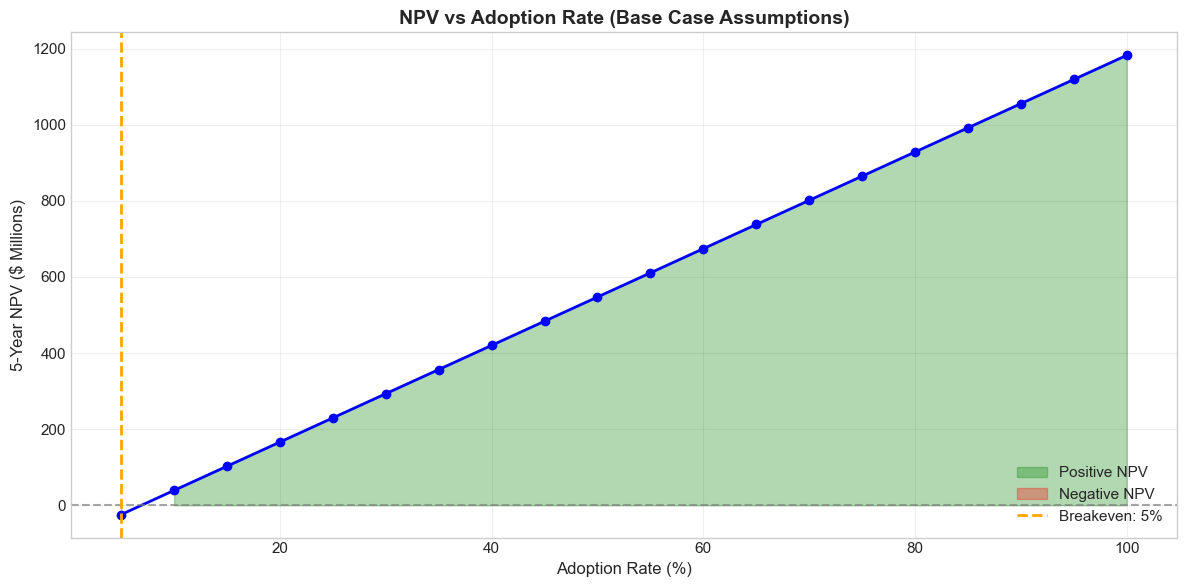

In [9]:
# Visualize adoption rate vs NPV curve
adoption_rates = np.linspace(0.05, 1.0, 20)
npvs = []

for rate in adoption_rates:
    scenario = AdoptionScenario(
        name="Test",
        adoption_rate=rate,
        shipper_escrow_pct=1.0,
        carrier_tech_ready_pct=1.0,
        tx_cost_per_load=5.0,
        fraud_reduction_pct=0.15,
        implementation_cost=50e6,
        annual_maintenance_cost=10e6,
    )
    result = run_scenario_analysis(params, scenario)
    npvs.append(result.npv_5yr)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(adoption_rates * 100, np.array(npvs) / 1e6, "b-", linewidth=2, marker="o")
ax.fill_between(
    adoption_rates * 100,
    np.array(npvs) / 1e6,
    where=np.array(npvs) > 0,
    alpha=0.3,
    color="green",
    label="Positive NPV",
)
ax.fill_between(
    adoption_rates * 100,
    np.array(npvs) / 1e6,
    where=np.array(npvs) <= 0,
    alpha=0.3,
    color="red",
    label="Negative NPV",
)
ax.axhline(y=0, color="gray", linestyle="--", alpha=0.7)

# Find breakeven point
breakeven_idx = np.argmin(np.abs(npvs))
ax.axvline(
    x=adoption_rates[breakeven_idx] * 100,
    color="orange",
    linestyle="--",
    linewidth=2,
    label=f"Breakeven: {adoption_rates[breakeven_idx]:.0%}",
)

ax.set_xlabel("Adoption Rate (%)", fontsize=12)
ax.set_ylabel("5-Year NPV ($ Millions)", fontsize=12)
ax.set_title(
    "NPV vs Adoption Rate (Base Case Assumptions)", fontsize=14, fontweight="bold"
)
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("results/figures.png", dpi=150, bbox_inches="tight")
plt.show()

## 4. Sensitivity Analysis


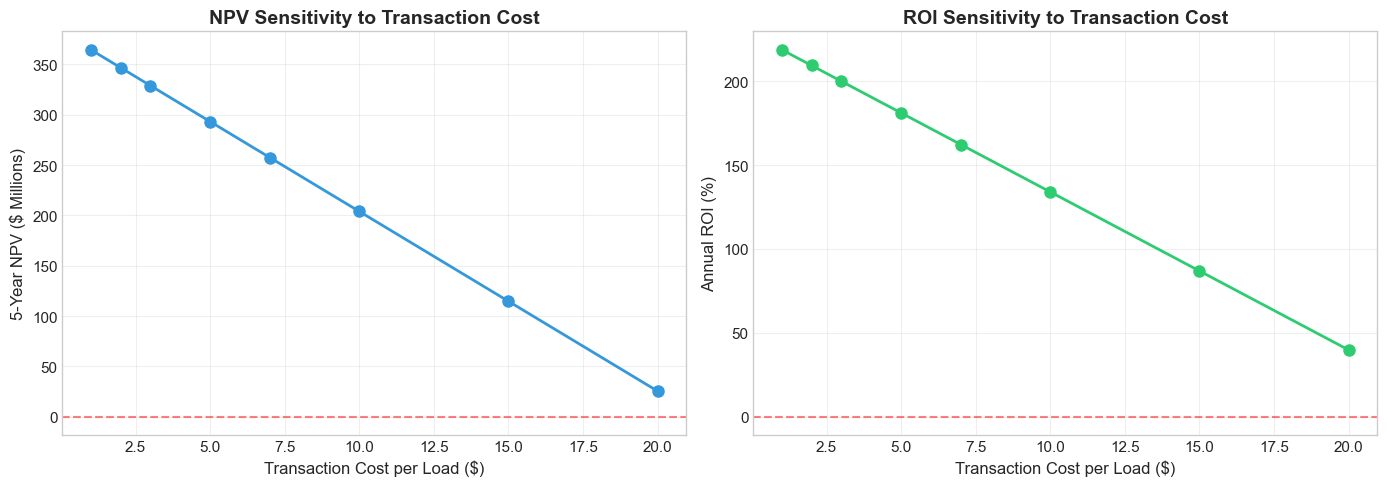

In [11]:
# Sensitivity to tx_cost_per_load
base_scenario = SCENARIOS["base_case"]
tx_costs_range = [1, 2, 3, 5, 7, 10, 15, 20]

tx_sensitivity = sensitivity_by_scenario_parameter(
    params, base_scenario, "tx_cost_per_load", tx_costs_range
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# NPV sensitivity to tx cost
axes[0].plot(
    tx_sensitivity["parameter_value"],
    tx_sensitivity["npv_5yr"] / 1e6,
    "o-",
    linewidth=2,
    markersize=8,
    color="#3498db",
)
axes[0].axhline(y=0, color="red", linestyle="--", alpha=0.5)
axes[0].set_xlabel("Transaction Cost per Load ($)", fontsize=12)
axes[0].set_ylabel("5-Year NPV ($ Millions)", fontsize=12)
axes[0].set_title("NPV Sensitivity to Transaction Cost", fontsize=14, fontweight="bold")
axes[0].grid(True, alpha=0.3)

# ROI sensitivity to tx cost
axes[1].plot(
    tx_sensitivity["parameter_value"],
    tx_sensitivity["roi"] * 100,
    "o-",
    linewidth=2,
    markersize=8,
    color="#2ecc71",
)
axes[1].axhline(y=0, color="red", linestyle="--", alpha=0.5)
axes[1].set_xlabel("Transaction Cost per Load ($)", fontsize=12)
axes[1].set_ylabel("Annual ROI (%)", fontsize=12)
axes[1].set_title("ROI Sensitivity to Transaction Cost", fontsize=14, fontweight="bold")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("results/figures.png", dpi=150, bbox_inches="tight")
plt.show()

## 5. Key Findings Summary


In [12]:
# Get summary statistics
summary = get_scenario_summary(results)

print("\n" + "=" * 70)
print("KEY FINDINGS: Adoption Scenario Analysis")
print("=" * 70)

print("\n1. SCENARIO RANGE")
print(
    f"   - Minimum Annual Savings: {format_currency(summary['min_annual_savings'])} (Conservative)"
)
print(
    f"   - Maximum Annual Savings: {format_currency(summary['max_annual_savings'])} (Aggressive)"
)
print(f"   - Average Annual Savings: {format_currency(summary['avg_annual_savings'])}")

print("\n2. INVESTMENT ANALYSIS")
print(f"   - Average 5-Year NPV: {format_currency(summary['avg_npv_5yr'])}")
print(f"   - Average Payback Period: {summary['avg_payback_years']:.1f} years")
print(
    f"   - All Scenarios Positive NPV: {'Yes' if summary['all_positive_npv'] else 'No'}"
)

print("\n3. BEST/WORST SCENARIOS")
print(f"   - Best Scenario: {summary['best_scenario']}")
print(f"   - Worst Scenario: {summary['worst_scenario']}")

print("\n4. KEY CONSTRAINTS")
print("   - Shipper escrow willingness is the primary constraint in most scenarios")
print("   - Carrier tech readiness is less of a barrier due to ELD mandates")
print("   - Transaction costs need to stay under $10/load for positive ROI")

print("\n5. RECOMMENDATIONS")
print("   - Target Base Case scenario (30% adoption) for initial deployment")
print("   - Focus on shipper education to increase escrow willingness")
print("   - Optimize blockchain infrastructure to minimize tx costs")
print("\n" + "=" * 70)


KEY FINDINGS: Adoption Scenario Analysis

1. SCENARIO RANGE
   - Minimum Annual Savings: $9.8M (Conservative)
   - Maximum Annual Savings: $296.3M (Aggressive)
   - Average Annual Savings: $144.1M

2. INVESTMENT ANALYSIS
   - Average 5-Year NPV: $496.2M
   - Average Payback Period: 2.1 years
   - All Scenarios Positive NPV: No

3. BEST/WORST SCENARIOS
   - Best Scenario: Aggressive
   - Worst Scenario: Conservative

4. KEY CONSTRAINTS
   - Shipper escrow willingness is the primary constraint in most scenarios
   - Carrier tech readiness is less of a barrier due to ELD mandates
   - Transaction costs need to stay under $10/load for positive ROI

5. RECOMMENDATIONS
   - Target Base Case scenario (30% adoption) for initial deployment
   - Focus on shipper education to increase escrow willingness
   - Optimize blockchain infrastructure to minimize tx costs

